In [10]:
import torch
from typing import TypeVar
from tqdm.auto import tqdm

from segmentation.scr.utils.rle_coding import *
from segmentation.scr.tilling_dataset import Tilling_Dataset
import matplotlib.pyplot as plt
from skimage import color
import albumentations as A

PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')

In [2]:
tilling_1 = Tilling_Dataset(
    name_data='kidney_1_tilling',
    path_to_df='data\\kidney_1_tilling.csv',
    use_random_sub=False,
    empty_tile_pct=0,
    sample_limit=None,
    transform=None
)

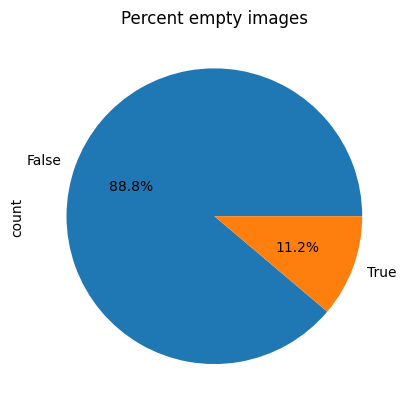

In [11]:
tilling_1.df['is_empty'].value_counts().plot.pie(y='type', autopct='%.1f%%', legend=False)
plt.title('Percent empty images');

In [ ]:
 A.ShiftScaleRotate(scale_limit=0.2, shift_limit = 0.1,rotate_limit=0, p= CFG.p_rot),

In [ ]:
tr =  A.GaussNoise(var_limit=0.05, p=1)
#A.Affine(scale={"x":(0.7, 1.3), "y":(0.7, 1.3)}, 
         #    translate_percent={"x":(0, 0.1), "y":(0, 0.1)}, 
            #  rotate=(-30, 30), shear=(-5, 5), p=1)
#A.GridDistortion(num_steps=5, distort_limit=0.1, border_mode=1, p=1)
#A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, border_mode=1, p=1)
#A.Affine(scale={"x":(0.7, 1.3), "y":(0.7, 1.3)}, 
 #             translate_percent={"x":(0, 0.1), "y":(0, 0.1)}, 
  #            rotate=(-30, 30), shear=(-10, 10), p=1)

In [ ]:
img, mask, bbx, size = tilling_1[24556]
img= torch.permute(img, (1,2,0)).numpy()
mask = mask.numpy()
fig, axarr = plt.subplots(ncols=3, figsize=(12, 6))
axarr[0].imshow(img, cmap="gray")
axarr[1].imshow(color.label2rgb(mask, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
axarr[2].imshow(mask, vmin=0, interpolation='antialiased', interpolation_stage='rgba')

In [ ]:
img, mask, bbx, size = tilling_1[24556]
augmented = tr(image=torch.permute(img, (1,2,0)).numpy(), mask=mask.numpy())  # c h w
img, mask = augmented["image"], augmented["mask"]



fig, axarr = plt.subplots(ncols=3, figsize=(12, 6))
axarr[0].imshow(img, cmap="gray")
axarr[1].imshow(color.label2rgb(mask, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
axarr[2].imshow(mask, vmin=0, interpolation='antialiased', interpolation_stage='rgba')

# Dataset statistic

In [12]:
loader = torch.utils.data.DataLoader(
    tilling_1 ,
    batch_size=5,
    
    shuffle=False,
    pin_memory=True
)

In [15]:
batch = next(iter(loader))

In [16]:
img = batch[0]

In [18]:
img.quantile(0.1)

tensor(0.1176)

In [25]:
def norm_with_clip(x:torch.Tensor,low=10, high=99.8, alpha=0.01):
    xmin = torch.quantile(x,low / 100)
    xmax = torch.quantile(x,high / 100)
    x = (x-xmin)/(xmax-xmin)
    if 1:
        x[x>1]=(x[x>1]-1)*alpha +1
        x[x<0]=(x[x<0])*alpha
    #x = np.clip(x,0,1)
    return x

    
norm_with_clip(img).max()

tensor(1.0543)

In [ ]:
def norm_by_percentile(volume, low=10, high=99.8, alpha=0.01):
    xmin = np.percentile(volume,low)
    xmax = np.percentile(volume,high)
    x = (volume-xmin)/(xmax-xmin)
    if 1:
        x[x>1]=(x[x>1]-1)*alpha +1
        x[x<0]=(x[x<0])*alpha
    #x = np.clip(x,0,1)
    return x

In [9]:
next(iter(loader))[0].shape

torch.Size([5, 3, 512, 512])

In [6]:
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

num_pixels = 0
pbar = tqdm(enumerate(loader), total=len(loader), desc='Calculate')
for step, batch in pbar:
    images, _, _, _ = batch
    batch_size, num_channels, height, width = images.shape
    num_pixels += batch_size * height * width
    
    psum += images.sum(axis=[0, 2, 3])
    psum_sq += (images**2).sum(axis=[0, 2, 3])

    
# mean and STD
total_mean = psum / num_pixels
total_var = (psum_sq / num_pixels)  - (total_mean ** 2)
total_std = torch.sqrt(total_var)

# output
print("mean: " + str(total_mean))
print("std:  " + str(total_std))


Calculate: 100%|██████████| 2735/2735 [01:18<00:00, 34.64it/s]

mean: tensor([0.2479, 0.2479, 0.2479])
std:  tensor([0.1773, 0.1773, 0.1773])


In [ ]:
img, mask, is_empty, bbx, size = data_loader[8]
augmented = train_transform(image=img,mask=mask)
img,mask = augmented['image'],augmented['mask']


fig, axarr = plt.subplots(ncols=3, figsize=(12, 6))
axarr[0].imshow(torch.permute(img, (1,2,0)).numpy(), cmap="gray")
axarr[1].imshow(color.label2rgb(mask.numpy(), torch.permute(img, (1,2,0)).numpy(), bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
axarr[2].imshow(mask, vmin=0, interpolation='antialiased', interpolation_stage='rgba')